The script follows the image classification (modeling) of the Paddy Disease, a Kaggle competition, as discussed in lecture 6 of the fastai course

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
print(np.__version__)

1.26.4


In [3]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [4]:
#comp = 'paddy-disease-classification'

#path = setup_comp(comp)#, install='fastai "timm>=0.6.2.dev0"')

In [5]:
from fastai.imports import *
np.set_printoptions(linewidth=130)
import os
from pathlib import Path
path = Path('/kaggle/input/paddy-doctor/paddy-disease-classification')
path

Path('/kaggle/input/paddy-doctor/paddy-disease-classification')

Defining a seed is useful for making reproducible output; for practical purposes, it should be avoided

In [6]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#6) [Path('/kaggle/input/paddy-doctor/paddy-disease-classification/sample_submission.csv'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/train_images'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/.jovianrc'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/.ipynb_checkpoints'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/train.csv'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images')]

**Training data**

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


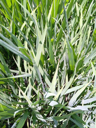

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [9]:
#Checking the size of all images

from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10407
Name: count, dtype: int64

Resize(480, method='squish'): Resizes the image to a 480x480 pixel size using the squish function

aug_transforms(size=128, min_scale=0.75): defines the size to which the images are randomly cropped during data augmentation. The crop is applied after the initial resize, so the model sees patches of size 128x128 during training. This helps the model learn to recognize features at different scales and positions.

min_scale=0.75: The minimum scale for random zooming during augmentation (i.e., the image can be zoomed in up to 1.33x, since 1/0.75 ≈ 1.33).

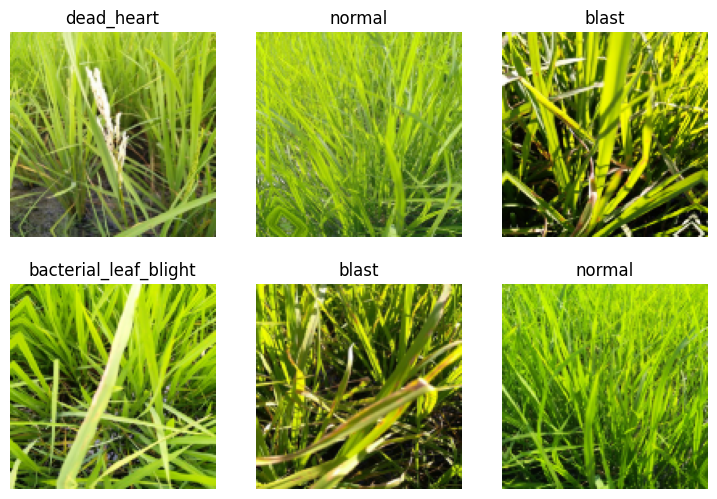

In [10]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

A training model is created using the vision model 'resnet26d', a fast model for initial checking and analysis

In [11]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

The 'lr_find' function provides a suggestion for the learning rate of the model. However, it should be noted that 'lr_find' generally recommends rather conservative learning rates. For successful training, it might be intuitive to push it a bit higher (as shown in the next step).

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


SuggestedLRs(valley=0.0012022644514217973, slide=0.0063095735386013985)

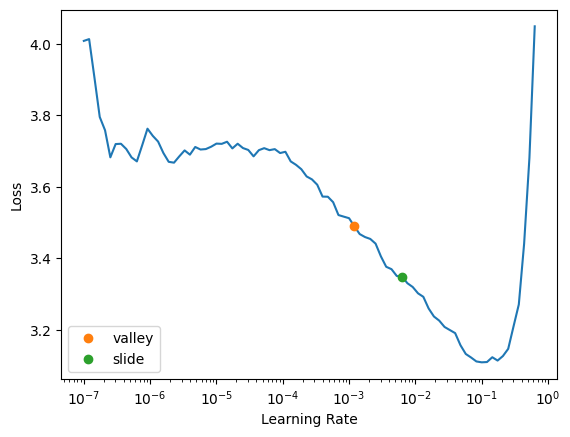

In [12]:
learn.lr_find(suggest_funcs=(valley, slide))

About 12% error, not ideal but something to start

In [13]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.818632,1.159760,0.380586,13:08


epoch,train_loss,valid_loss,error_rate,time
0,1.142663,0.777934,0.257088,16:48
1,0.759083,0.446104,0.148486,16:59
2,0.541245,0.378613,0.120135,17:29


**The Testing data**

In [14]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


A CSV output file containing all the test images, in alphabetical order, and the predicted label is generated

'dls' from the earlier training transforms the test data into a similar format

In [21]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)
tst_files

(#3469) [Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200001.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200002.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200003.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200004.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200005.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200006.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200007.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200008.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200009.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200010.jpg'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images/200011.jpg'),Path('/kaggle/input/paddy-doctor/p

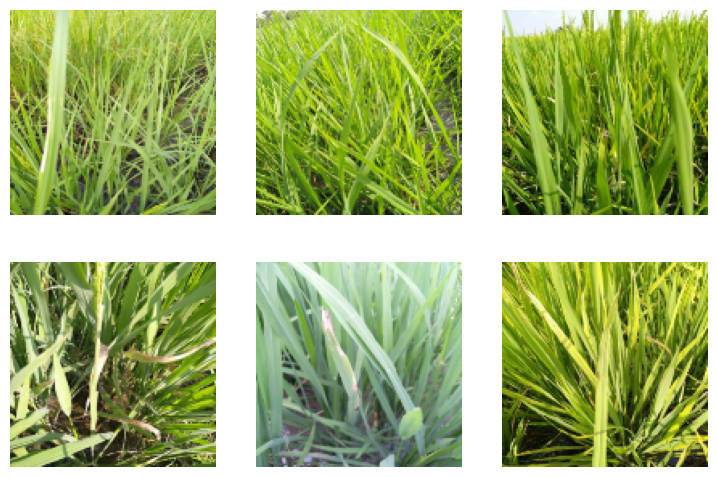

In [20]:
tst_dl.show_batch(max_n=6)

The probabilities of each class and the index of the most likely class are determined for each image in the test set. The second thing returned by get_preds is the targets, which are blank for a test set and so are discarded.

In [23]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
probs, idxs

(tensor([[1.2541e-03, 4.0723e-06, 1.0947e-06,  ..., 9.6824e-01, 1.4698e-04,
          6.1809e-05],
         [9.3392e-04, 9.3440e-05, 2.8490e-04,  ..., 1.7590e-01, 7.2362e-01,
          5.5226e-02],
         [6.0019e-04, 2.0052e-03, 8.1822e-04,  ..., 6.4483e-01, 3.4629e-03,
          7.9198e-04],
         ...,
         [7.1900e-07, 9.3853e-07, 4.3403e-08,  ..., 9.9102e-06, 9.9998e-01,
          1.2969e-06],
         [6.2596e-04, 9.6686e-01, 4.4629e-03,  ..., 1.5683e-02, 3.5061e-03,
          3.4045e-04],
         [1.8027e-05, 4.6831e-08, 1.5304e-05,  ..., 2.0957e-05, 1.0035e-04,
          8.2356e-04]]),
 tensor([7, 8, 7,  ..., 8, 1, 5]))

In [25]:
probs.size(), idxs.size()

(torch.Size([3469, 10]), torch.Size([3469]))

The indices need to be mapped to the respective names of the diseases (stored in the vocab)

In [17]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [18]:
#The indices and names are mapped using pandas

mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

**Output**

In [19]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
